In [39]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import layers
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Input
from keras.optimizers import Adam, Adamax
from keras.metrics import categorical_crossentropy
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML
from sklearn.metrics import accuracy_score
from keras.applications import VGG16

from skimage.feature import graycomatrix, graycoprops
from skimage.io import imread
from skimage.color import rgb2gray

from skimage import img_as_ubyte


In [40]:
# Definisikan direktori Anda
sdir_train = r'E:\TRAINING SKRIPSI\Coba'

filepaths = []
labels = []
glcm_features = []

classlist = os.listdir(sdir_train)
for klass in classlist:
    classpath = os.path.join(sdir_train, klass)
    if os.path.isdir(classpath):
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            
            # Load the image
            img = imread(fpath)
            # Convert the image to grayscale
            gray_img = rgb2gray(img)
            # Convert the grayscale image to unsigned integer (0-255)
            gray_img_uint = img_as_ubyte(gray_img)
            # Compute the GLCM matrix
            glcm = graycomatrix(gray_img_uint, distances=[1], angles=[0], levels=256)
            # Calculate GLCM properties
            contrast = graycoprops(glcm, 'contrast')[0, 0]
            dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
            
            # Add the GLCM features, filepath, and label to the lists
            glcm_features.append([contrast, dissimilarity])
            filepaths.append(fpath)
            labels.append(klass)

In [41]:
# Create the dataframe
data = {'filepaths': filepaths, 'labels': labels, 'glcm_features': glcm_features}
df = pd.DataFrame(data)

# Split the dataframe into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['labels'], random_state=42)

# Define image dimensions
img_height, img_width = 150, 150

In [42]:
# Create data generators for training and validation sets
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical')

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical')

Found 382 validated image filenames belonging to 3 classes.


Found 96 validated image filenames belonging to 3 classes.


In [43]:
# Load the VGG16 pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [44]:
# Build the classification model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

In [45]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [46]:
model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [47]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 16812867 (64.14 MB)
Trainable params: 16812867 (64.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
# Define the callbacks
checkpoint = ModelCheckpoint('Cobaa40.h5', save_best_only=True)

In [49]:
# Train the model
history = model.fit(train_generator, epochs=40, validation_data=val_generator, callbacks=[checkpoint])


Epoch 1/40
12/12 [==============================] - ETA: 0s - loss: 1.1397 - accuracy: 0.4398 

c:\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
c:\Python\Python311\Lib\site-packages\keras\src\regularizers.py:424: UserWarning: The `keras.regularizers.serialize()` API should only be used for objects of type `keras.regularizers.Regularizer`. Found an instance of type <class 'NoneType'>, which may lead to improper serialization.
  warnings.warn(
c:\Python\Python311\Lib\site-packages\keras\src\constraints.py:363: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'NoneType'>, which may lead to improper serialization.
  warnings.warn(


12/12 [==============================] - 222s 16s/step - loss: 1.1397 - accuracy: 0.4398 - val_loss: 0.8331 - val_accuracy: 0.5833
Epoch 2/40
12/12 [==============================] - 241s 20s/step - loss: 0.8538 - accuracy: 0.5681 - val_loss: 0.7387 - val_accuracy: 0.6146
Epoch 3/40
12/12 [==============================] - 177s 15s/step - loss: 0.6627 - accuracy: 0.6859 - val_loss: 0.5761 - val_accuracy: 0.7604
Epoch 4/40
12/12 [==============================] - 181s 15s/step - loss: 0.4929 - accuracy: 0.7827 - val_loss: 0.4106 - val_accuracy: 0.8542
Epoch 5/40
12/12 [==============================] - 166s 14s/step - loss: 0.3310 - accuracy: 0.8717 - val_loss: 0.2978 - val_accuracy: 0.8854
Epoch 6/40
12/12 [==============================] - 162s 14s/step - loss: 0.2724 - accuracy: 0.8848 - val_loss: 0.2602 - val_accuracy: 0.8958
Epoch 7/40
12/12 [==============================] - 160s 13s/step - loss: 0.1661 - accuracy: 0.9346 - val_loss: 0.2085 - val_accuracy: 0.9271
Epoch 8/40
12/12 

In [50]:
# Print the test loss and accuracy
val_loss, val_acc = model.evaluate(val_generator)
print('Validation Loss:', val_loss)
print('Validation Accuracy: {:.2f}%'.format(val_acc * 100))

3/3 [==============================] - 8s 2s/step - loss: 0.2772 - accuracy: 0.9167
Validation Loss: 0.2772071361541748
Validation Accuracy: 91.67%


In [51]:
# Function to print text in colored foreground and background
def color_text(text, foreground_color='black', background_color='white'):
    return f'\033[38;5;{foreground_color};48;5;{background_color}m{text}\033[0m'


In [52]:
# Define a function to print information about misclassifications
def print_info(generator, preds, print_code):
    class_dict = generator.class_indices
    labels = generator.labels
    file_names = generator.filenames
    error_list = []
    true_class = []
    pred_class = []
    prob_list = []
    new_dict = {}
    error_indices = []
    y_pred = []
    for key, value in class_dict.items():
        new_dict[value] = key  # dictionary {integer of class number: string of class name}
    # store new_dict as a text file in the save_dir
    classes = list(new_dict.values())  # list of string of class names
    dict_as_text = str(new_dict)
    errors = 0
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = labels[i]  # labels are integer values
        if pred_index != true_index:  # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors = errors + 1
        y_pred.append(pred_index)
    if print_code != 0:
        if errors > 0:
            if print_code > errors:
                r = errors
            else:
                r = print_code
            msg = '{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class', 'True Class', 'Probability')
            print(msg)
            for i in range(r):
                split1 = os.path.split(error_list[i])
                split2 = os.path.split(split1[0])
                fname = split2[1] + '/' + split1[1]
                msg = '{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i], true_class[i], ' ',
                                                                         prob_list[i])
                print(msg)
        else:
            msg = 'With accuracy of 100 % there are no errors to print'
            print(msg)
    if errors > 0:
        plot_bar = []
        plot_class = []
        for key, value in new_dict.items():
            count = error_indices.count(key)
            if count != 0:
                plot_bar.append(count)  # list containing how many times a class c had an error
                plot_class.append(value)  # stores the class
        fig = plt.figure()
        fig.set_figheight(len(plot_class) / 3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c = plot_class[i]
            x = plot_bar[i]
            plt.barh(c, x)
            plt.title('Errors by Class on Validation Set')
    y_true = np.array(labels)
    y_pred = np.array(y_pred)
    if len(classes) <= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        length = len(classes)
        if length < 8:
            fig_width = 8
            fig_height = 8
        else:
            fig_width = int(length * .5)
            fig_height = int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length) + .5, classes, rotation=90)
        plt.yticks(np.arange(length) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)


3/3 [==============================] - 11s 3s/step


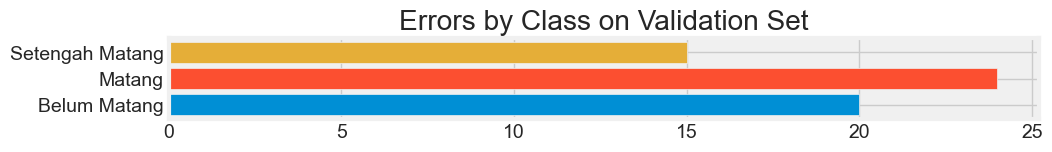

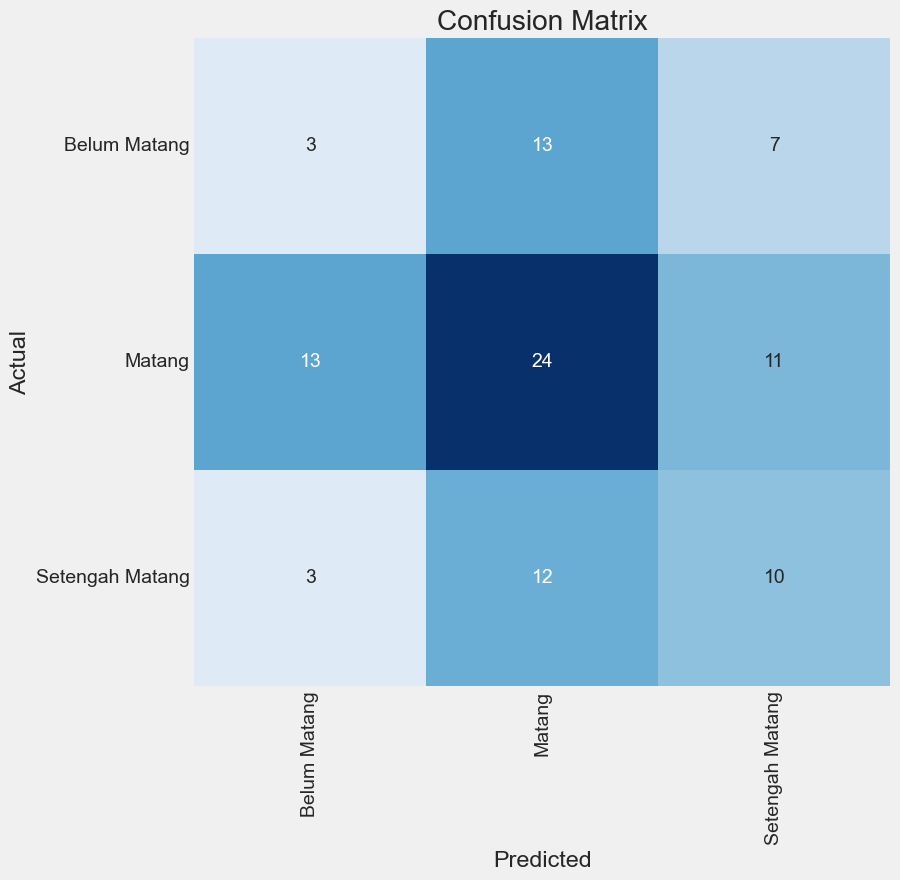

Classification Report:
----------------------
                  precision    recall  f1-score   support

   Belum Matang       0.16      0.13      0.14        23
         Matang       0.49      0.50      0.49        48
Setengah Matang       0.36      0.40      0.38        25

       accuracy                           0.39        96
      macro avg       0.33      0.34      0.34        96
   weighted avg       0.38      0.39      0.38        96



In [53]:
print_code = 0
preds = model.predict(val_generator)  # Gunakan val_generator untuk dataset validasi
print_info(val_generator, preds, print_code)

12/12 [==============================] - 33s 3s/step


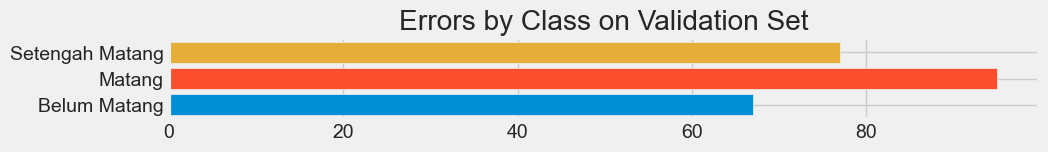

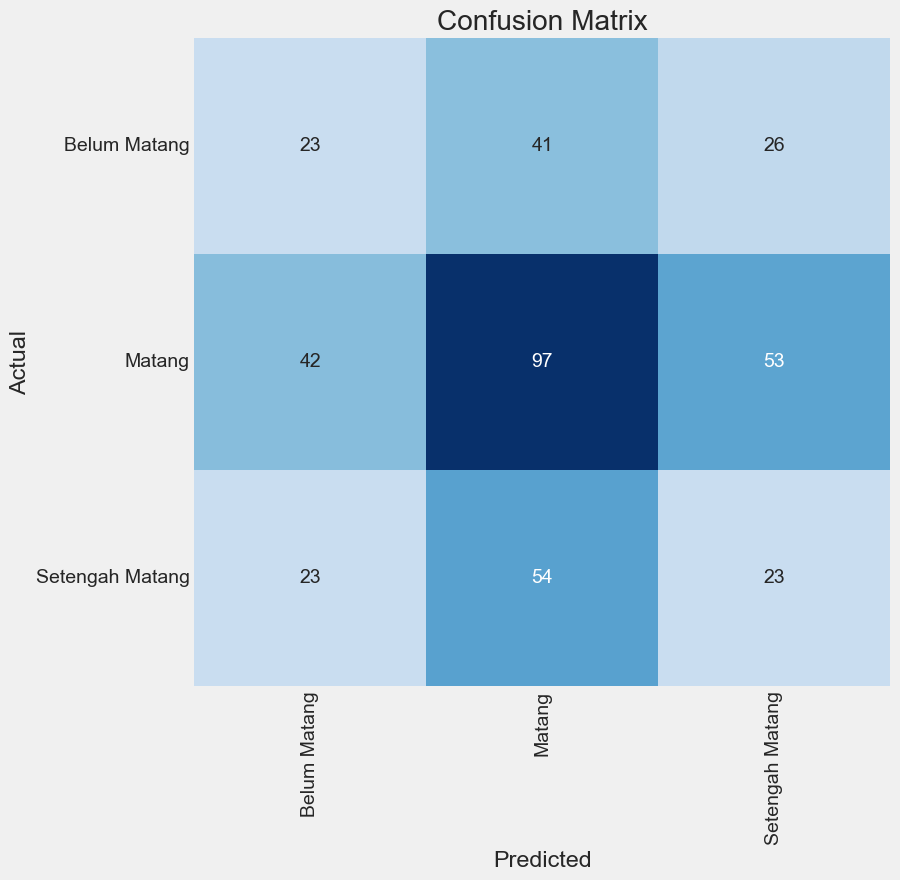

Classification Report:
----------------------
                  precision    recall  f1-score   support

   Belum Matang       0.26      0.26      0.26        90
         Matang       0.51      0.51      0.51       192
Setengah Matang       0.23      0.23      0.23       100

       accuracy                           0.37       382
      macro avg       0.33      0.33      0.33       382
   weighted avg       0.37      0.37      0.37       382



In [54]:
print_code = 0
preds = model.predict(train_generator)  # Gunakan val_generator untuk dataset validasi
print_info(train_generator, preds, print_code)

In [55]:
# Plot the training and validation data
def plot_metrics(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

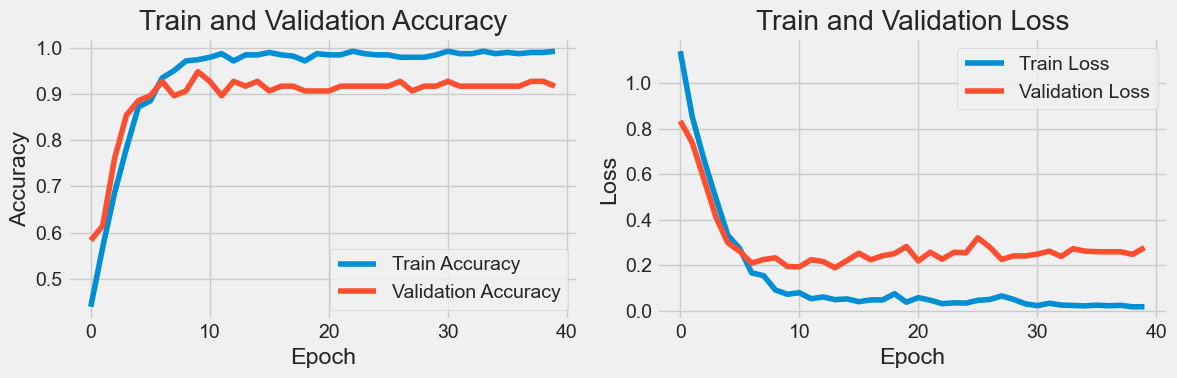

In [56]:
plot_metrics(history)
